In [ ]:
# load all required libraries for Dog's Breed Identification Project
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [7]:
#read the csv file
df_labels = pd.read_csv("/content/labels.csv")
#store training and testing images folder location
train_file = '/content/train.zip'
test_file = '/content/test.zip'

In [8]:
#check the total number of unique breed in our dataset file
print("Total number of unique Dog Breeds :",len(df_labels.breed.unique()))

Total number of unique Dog Breeds : 120


In [9]:
#specify number
num_breeds = 60
im_size = 224
batch_size = 64
encoder = LabelEncoder()

In [10]:
#get only 60 unique breeds record
breed_dict = list(df_labels['breed'].value_counts().keys())
new_list = sorted(breed_dict,reverse=True)[:num_breeds*2+1:2]
#change the dataset to have only those 60 unique breed records
df_labels = df_labels.query('breed in @new_list').copy()

train_image_directory = '/content/train.zip'
df_labels['img_path'] = df_labels['id'].apply(lambda x: train_image_directory + x + '.jpg')

# Display the first few rows of the modified DataFrame to verify
display(df_labels.head())

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/train.zip000bec180eb18c7604dcecc8fe0d...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/train.zip001513dfcb2ffafc82cccf4d8bba...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/train.zip001cdf01b096e06d78e9e5112d41...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/train.zip00214f311d5d2247d5dfe4fe24b2...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/train.zip0021f9ceb3235effd7fcde7f7538...


In [19]:
import zipfile
import os

zip_path = "/content/dog-breed-identification (1).zip"
extract_path = "/content/dog_breed_dataset"

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipping complete!\n")



✅ Unzipping complete!



In [20]:
# Ensure necessary libraries are imported within this cell
import cv2
import numpy as np
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import os # Import os for path joining

#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(df_labels), im_size, im_size, 3), dtype='float32')

# Create the 'img_file' column by adding .jpg to the 'id' column
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + '.jpg')

# Define the directory where the training images are located
train_images_directory = '/content/dog_breed_dataset/train'

#iterate over img_file column of our dataset
for i, img_file in enumerate(df_labels['img_file']):
  # Construct the full path to the image file
  img_path = os.path.join(train_images_directory, img_file)
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
  # Use the correct img_path to read the image
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)

  # Check if the image was read successfully
  if img is not None:
      img = cv2.resize(img, ((im_size, im_size)))
      #scale array into the range of -1 to 1.
      #preprocess the array and expand its dimension on the axis 0
      img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
      #update the train_x variable with new element
      train_x[i] = img_array
  else:
      print(f"Warning: Could not read image file: {img_path}. Skipping.")

In [21]:
#This will be the target for the model.
#convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)

In [22]:
#split the dataset in the ratio of 80:20.
#80% for training and 20% for testing purpose
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

In [23]:
#Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#generate images for training sets
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=batch_size)

#same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(x_test,
                                     y_test,
                                     batch_size=batch_size)

In [24]:
#building the model using ResNet50V2 with input shape of our image array
#weights for our network will be from of imagenet dataset
#we will not include the first Dense layer
resnet = ResNet50V2(input_shape = [im_size,im_size,3], weights='imagenet', include_top=False)
#freeze all trainable layers and train only top layers
for layer in resnet.layers:
    layer.trainable = False

#add global average pooling layer and Batch Normalization layer
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
#add fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [53]:
#add output layer having the shape equal to number of breeds
predictions = Dense(num_breeds, activation='softmax')(x)

#create model class with inputs and outputs
model = Model(inputs=resnet.input, outputs=predictions)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,732,668 (98.16 MB)

 Trainable params: 2,163,772 (8.25 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [27]:
#epochs for model training and learning rate for optimizer
epochs = 30
learning_rate = 1e-3

#using RMSprop optimizer to compile or build the model
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

#fit the training generator data and train the model
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)

#Save the model for prediction
model.save("model.keras")

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 66s 865ms/step - accuracy: 0.7537 - loss: 0.7952 - val_accuracy: 0.8008 - val_loss: 0.6561
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7188 - loss: 1.1146 - val_accuracy: 0.8008 - val_loss: 0.6726
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7867 - loss: 0.6670 - val_accuracy: 0.7998 - val_loss: 0.7338
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7344 - loss: 0.9349 - val_accuracy: 0.7988 - val_loss: 0.7127
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7940 - loss: 0.6991 - val_accuracy: 0.8086 - val_loss: 0.7023
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6719 - loss: 1.1955 - val_accuracy: 0.8096 - val_loss: 0.6928
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7762 - loss: 0.7048 - val_accuracy: 0.8076 - val_loss: 0.7119
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7500 - loss: 0.8379 - val_accuracy: 0.8057 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


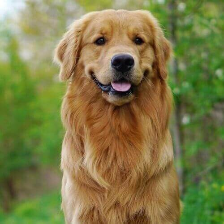

Predicted Breed for this Dog is : golden_retriever


In [44]:
#load the model
model = load_model("model.keras")

#get the image of the dog for prediction
pred_img_path = '/content/golden-retriever-dog-breed-info.jpeg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


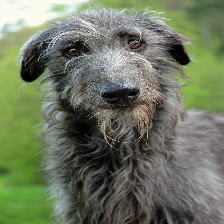

Predicted Breed for this Dog is : scottish_deerhound


In [45]:
#load the model
model = load_model("model.keras")

#get the image of the dog for prediction
pred_img_path = '/content/th78sb7eemm91.webp'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


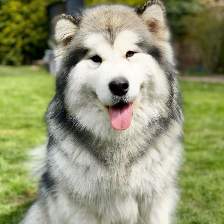

Predicted Breed for this Dog is : malamute


In [46]:
#load the model
model = load_model("model.keras")

#get the image of the dog for prediction
pred_img_path = '/content/9623b0d6adca9b53197b71d0283090cdc9cb0af2-1110x1110.webp'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


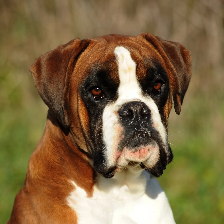

Predicted Breed for this Dog is : boxer


In [47]:
#load the model
model = load_model("model.keras")

#get the image of the dog for prediction
pred_img_path = '/content/close-up-portrait-of-a-boxer-dog.webp'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


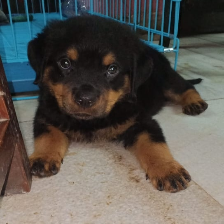

Predicted Breed for this Dog is : rottweiler


In [49]:
#load the model
model = load_model("model.keras")

#get the image of the dog for prediction
pred_img_path = '/content/rottweiler.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


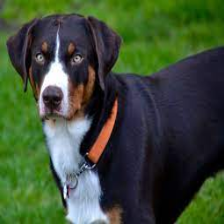

Predicted Breed for this Dog is : appenzeller


In [50]:
#load the model
model = load_model("model.keras")

#get the image of the dog for prediction
pred_img_path = '/content/images.jpg'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


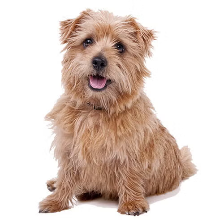

Predicted Breed for this Dog is : norfolk_terrier


In [52]:
#load the model
model = load_model("model.keras")

#get the image of the dog for prediction
pred_img_path = '/content/BREED Hero_0089_norfolk_terrier.avif'
#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

#display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size))))

#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)